##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [901]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [902]:
orig_df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [903]:
df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [904]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [905]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [906]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [907]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


Input variables:
- `X` and `Y` respectively indicate the longitude and latitude of the crime
- `Area_Command` indicates the area of the crime
- `NIBRSOffenseCode` indicates the type of crime
- `DayOfWeek` indicates the day of the week the crime was committed
- `Time` indicates the time of the day the crime was committed

Target variable:
- `VictimCount` indicates the number of victims in the crime

Range of values for each column:

In [908]:
# Print the min and max of each column
print(df.min())
print(df.max())

X                  -116.000000
Y                    35.068419
Area_Command          0.000000
NIBRSOffenseCode      0.000000
DayOfWeek             0.000000
Time                  0.000000
VictimCount           0.000000
dtype: float64
X                  -114.62557
Y                    37.00000
Area_Command         11.00000
NIBRSOffenseCode      2.00000
DayOfWeek             6.00000
Time                 23.00000
VictimCount           6.00000
dtype: float64


We need to normalize our data because they have different ranges. For example, the X coordinate ranges within negative values while the other columns are positive. We will make sure to normalize the columns so that our model can read in the data more uniformly and make better predictions.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [909]:
# Make last 20% of data test set
test_size = int(len(df) * 0.2)
train_size = len(df) - test_size

batch_size = 40
n_iters = 3000
num_epochs = n_iters / (train_size / batch_size)
num_epochs = int(np.ceil(num_epochs))

print("Train size:", train_size)
print("Test size:", test_size)
print("Num epochs:", num_epochs)

# Normalize only the X and Y columns to be continuous values between 0 and 1
df['X'] = (df['X'] - df['X'].min()) / (df['X'].max() - df['X'].min())
df['Y'] = (df['Y'] - df['Y'].min()) / (df['Y'].max() - df['Y'].min())

# Split data
x_train, y_train = df.values[:train_size, :-1], df.values[:train_size, -1]
x_test, y_test = df.values[train_size:, :-1], df.values[train_size:, -1]

# Transform to tensors
tensor_x_train, tensor_y_train = torch.Tensor(x_train), torch.Tensor(y_train)
tensor_x_test, tensor_y_test = torch.Tensor(x_test), torch.Tensor(y_test)

# Convert to TensorDataset
dataset_train = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
dataset_test = torch.utils.data.TensorDataset(tensor_x_test, tensor_y_test)

# Conver to DataLoader
dl_train = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

# Print shape of datasets
for x, y in dl_train:
    print("Train shape:", x.shape, y.shape)
    break

for x, y in dl_test:
    print("Test shape:", x.shape, y.shape)
    break

df.head()

Train size: 220
Test size: 55
Num epochs: 546
Train shape: torch.Size([40, 6]) torch.Size([40])
Test shape: torch.Size([40, 6]) torch.Size([40])


,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,0.663899,0.594478,0,0,0,0,0
1,0.552832,0.580495,1,1,1,1,0
2,0.623467,0.576165,2,1,2,0,1
3,0.563860,0.543189,3,1,1,2,2
4,0.599006,0.531973,4,1,1,3,0


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [910]:
# Define the proper loss function
loss = torch.nn.MSELoss()

# Size of predicted output
output_size = 1

# Create model architecture
class CrimeStats(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CrimeStats, self).__init__()
        # Three layers of linear transformations
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass data through each layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

# Initialize model
model = CrimeStats(x_train.shape[1], 128, output_size)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Keep track of best MSE achieved
best_MSE = np.inf

for epoch in range(num_epochs):
    model.train()
    for x, y in dl_train:
        # Forward pass
        y_pred = model(x)
        # Compute Loss
        l = loss(y_pred, y.unsqueeze(1))
        # Backward pass
        l.backward()
        # Update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
    # Calculate MSE error on test data and print it
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for x, y in dl_test:
            predictions = model(x)
            test_loss += loss(predictions, y.unsqueeze(1)).item()
    curr_MSE = (test_loss / len(dl_test))
    best_MSE = min(best_MSE, curr_MSE)
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Test MSE: {curr_MSE}')

print("Best MSE:", best_MSE)

Epoch [1/546] - Test MSE: 12.47806453704834
Epoch [2/546] - Test MSE: 10.201112270355225
Epoch [3/546] - Test MSE: 8.062114715576172
Epoch [4/546] - Test MSE: 1.872945785522461
Epoch [5/546] - Test MSE: 1.7322068214416504
Epoch [6/546] - Test MSE: 2.03659987449646
Epoch [7/546] - Test MSE: 1.6701716780662537
Epoch [8/546] - Test MSE: 1.3717514872550964
Epoch [9/546] - Test MSE: 1.328358143568039
Epoch [10/546] - Test MSE: 1.3207192122936249
Epoch [11/546] - Test MSE: 1.377437025308609
Epoch [12/546] - Test MSE: 1.3560719192028046
Epoch [13/546] - Test MSE: 1.340732902288437
Epoch [14/546] - Test MSE: 1.3500410616397858
Epoch [15/546] - Test MSE: 1.2899414598941803
Epoch [16/546] - Test MSE: 1.3003019988536835
Epoch [17/546] - Test MSE: 1.2967497110366821
Epoch [18/546] - Test MSE: 1.3189318180084229
Epoch [19/546] - Test MSE: 1.2705935835838318
Epoch [20/546] - Test MSE: 1.2980300188064575
Epoch [21/546] - Test MSE: 1.2756683826446533
Epoch [22/546] - Test MSE: 1.2825764417648315
Epoch

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [911]:
# Define the proper loss function
loss = torch.nn.CrossEntropyLoss()

# Size of predicted output
output_size = 7

# Create model architecture
class CrimeStats(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(CrimeStats, self).__init__()
        # Four layers of linear transformations
        self.layer1 = torch.nn.Linear(input_size, 256)
        self.layer2 = torch.nn.Linear(256, 128)
        self.layer3 = torch.nn.Linear(128, 64)
        self.layer4 = torch.nn.Linear(64, output_size)

    def forward(self, x):
        # Pass data through each layer
        x = self.layer1(x)
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)
        return x

# Initialize model
model = CrimeStats(x_train.shape[1], output_size)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Keep track of best accuracy achieved
best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    for x, y in dl_train:
        # Forward pass
        y_pred = model(x)
        # Compute Loss
        l = loss(y_pred, y.view(-1).long())
        # Backward pass
        l.backward()
        # Update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
    # Calculate accuracy on test data and print it
    model.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in dl_test:
            predictions = model(x)
            _, predicted_labels = torch.max(predictions, 1)
            correct_predictions += (predicted_labels == y.view(-1).long()).sum().item()
            total_samples += y.size(0)
    accuracy = 100 * (correct_predictions / total_samples)
    best_accuracy = max(best_accuracy, accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Test Accuracy: {accuracy}')

print("Best Accuracy:", best_accuracy)

Epoch [1/546] - Test Accuracy: 40.0
Epoch [2/546] - Test Accuracy: 49.09090909090909
Epoch [3/546] - Test Accuracy: 50.90909090909091
Epoch [4/546] - Test Accuracy: 49.09090909090909


Epoch [5/546] - Test Accuracy: 49.09090909090909
Epoch [6/546] - Test Accuracy: 50.90909090909091
Epoch [7/546] - Test Accuracy: 52.72727272727272
Epoch [8/546] - Test Accuracy: 43.63636363636363
Epoch [9/546] - Test Accuracy: 50.90909090909091
Epoch [10/546] - Test Accuracy: 52.72727272727272
Epoch [11/546] - Test Accuracy: 49.09090909090909
Epoch [12/546] - Test Accuracy: 50.90909090909091
Epoch [13/546] - Test Accuracy: 45.45454545454545
Epoch [14/546] - Test Accuracy: 49.09090909090909
Epoch [15/546] - Test Accuracy: 49.09090909090909
Epoch [16/546] - Test Accuracy: 45.45454545454545
Epoch [17/546] - Test Accuracy: 49.09090909090909
Epoch [18/546] - Test Accuracy: 43.63636363636363
Epoch [19/546] - Test Accuracy: 40.0
Epoch [20/546] - Test Accuracy: 49.09090909090909
Epoch [21/546] - Test Accuracy: 49.09090909090909
Epoch [22/546] - Test Accuracy: 41.81818181818181
Epoch [23/546] - Test Accuracy: 47.27272727272727
Epoch [24/546] - Test Accuracy: 47.27272727272727
Epoch [25/546] - T

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

We can compare the results by determining which is more accurate by looking at the best MSE of the regression model and the best accuracy of the classification model.

- Regression model: `Best MSE: 1.19645956158638`
- Classification model: `Best Accuracy: 54.54545454545454`

As to which one worked better, it depends on our goal. If our concern is to predict the exact number of victims accurately, it would be best to go with the regression model as the MSE that we acquired ended up pretty low. If our goal was to classify the number of victims into categories 0 to 6 inclusive, then the classification model would be a better choice, although the accuracy isn't too promising.

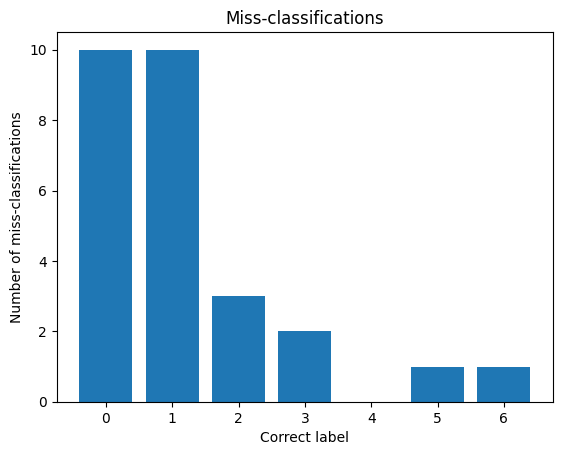

In [912]:
"""
Write a piece of code that finds an example of a  miss-classification. 
Calculate the probabilities for the output classes and plot them in a bar chart. 
Also, indicate what is the correct class label.
"""

# Go through the test data and record the miss-classifications and their true labels
miss_classifications = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
with torch.no_grad():
  for x, y in dl_test:
      predictions = model(x)
      _, predicted_labels = torch.max(predictions, 1)
      for i in range(len(predicted_labels)):
          if predicted_labels[i] != y[i].long():
              miss_classifications[y[i].long().item()] += 1

# Plot the miss-classifications in a bar chart
plt.bar(miss_classifications.keys(), miss_classifications.values())
plt.title("Miss-classifications")
plt.xlabel("Correct label")
plt.ylabel("Number of miss-classifications")
plt.show()


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


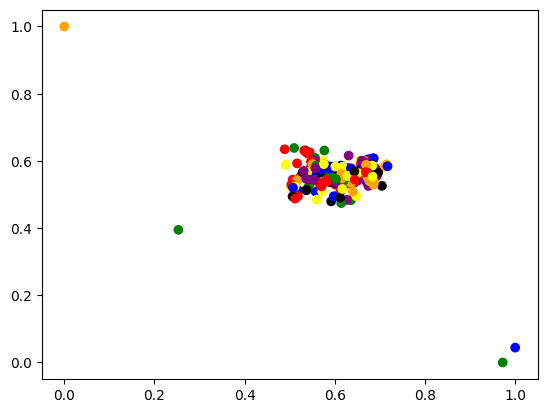

In [913]:
# Gather the columns
Xcoords = df['X']
Ycoords = df['Y']
DayOfWeek = df['DayOfWeek']

# Set each day of the week to a different color
"""
According to the way our dataset was created, 
the days of the week are encoded as follows:
0: Friday
1: Thursday
2: Tuesday
3: Saturday
4: Sunday
5: Monday
6: Wednesday
"""

colors = {
  5: 'red', # Monday
  2: 'orange', # Tuesday
  6: 'yellow', # Wednesday
  1: 'green', # Thursday
  0: 'blue', # Friday
  3: 'purple', # Saturday
  4: 'black' # Sunday
}

# Plot the data
plt.scatter(Xcoords, Ycoords, c=DayOfWeek.apply(lambda x: colors[x]))

The obvious pattern in the above plot is that the vast majority of the crimes occur within a specific region in the data's X and Y coordinate range. We can see that there are only four crimes outside of this precise region, and they are crimes that occurred near the end of the week (Thursday - Friday). All Monday, Wednesday, Saturday, and Sunday crimes occured within the clustered region mentioned.

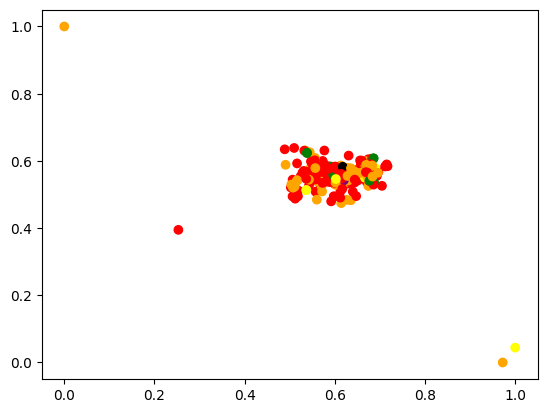

In [914]:
# Gather the column
VictimCount = df['VictimCount']

# Set each victim count to a different color
victims = {
  0: 'red',
  1: 'orange',
  2: 'yellow',
  3: 'green',
  4: 'blue',
  5: 'purple',
  6: 'black'
}

# Plot the data
plt.scatter(Xcoords, Ycoords, c=VictimCount.apply(lambda x: victims[x]))

We can see that all the crimes outside the clustered region affected 0-2 victims. All crimes with 3-6 victims occured within the clustered region.

DayOfWeek
4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: count, dtype: int64


Text(0, 0.5, 'Number of crimes')

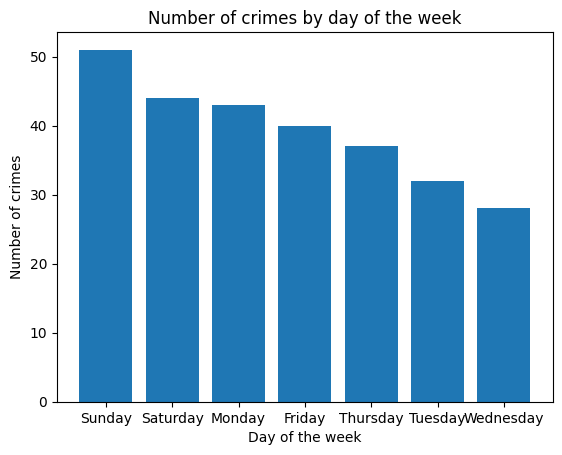

In [915]:
"""
According to the way our dataset was created, 
the days of the week are encoded as follows:
0: Friday
1: Thursday
2: Tuesday
3: Saturday
4: Sunday
5: Monday
6: Wednesday
"""

days = {
  0: 'Friday',
  1: 'Thursday',
  2: 'Tuesday',
  3: 'Saturday',
  4: 'Sunday',
  5: 'Monday',
  6: 'Wednesday',
}

# Sort the number of crimes by day of the week
crimes = df['DayOfWeek'].value_counts()
print(crimes)
# Get the values
values = crimes.values
# Get the labels
labels = crimes.index
# Convert the labels to the actual days of the week
days = [days[label] for label in labels]

# Plot the data
plt.bar(days, values)
plt.title("Number of crimes by day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Number of crimes")

Saturday to Monday are the top 3 days of the week that the most crimes have occurred.